In [108]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from pathlib import Path
import os
import sys

import joblib
import json
import pickle

import warnings
warnings.filterwarnings('ignore')

In [109]:
file_path = 'C:\\Users\\NikoWang\\OneDrive - endurancedirect.com\\Documents\\Actuarial Work\\ML Project\\Data.csv'
df = pd.read_csv(file_path, delimiter=",")

In [110]:
# Show the first 10 rows of the dataframe
df.head(10)

,Contract_Number,Sale_Date,Cancel_Date,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status,Duration
0,83524003419,2012-02-20,NaN,0.0,18.0,BMW,525,44371,N,92371,12,48000.0,3746.0,250.0,0.00,2078.0,NaN,NaN,Not_Cancelled,0.0
1,83524005048,2012-05-10,NaN,0.0,16.0,GMC,SIERRA,29877,N,89877,12,60000.0,2993.0,195.0,0.00,909.0,NaN,NaN,Not_Cancelled,0.0
2,SAH010581,2016-12-30,NaN,0.0,17.0,BMW,X3,83211,U,143211,12,60000.0,3895.0,205.0,0.00,1565.0,NaN,NaN,Not_Cancelled,0.0
3,179001410,2012-06-01,2012-06-05,48.0,22.0,MERZ,MESL5,40980,N,140980,18,100000.0,5875.0,1500.0,0.00,3465.0,NaN,NaN,Cancelled,0.0
4,83524018310,2015-07-16,2016-02-15,48.0,17.0,HYUN,HYACC,166559,U,241559,18,75000.0,3325.0,175.0,175.00,1213.0,NaN,NaN,Cancelled,7.0
5,2007615DAS,2012-03-21,2012-08-21,60.0,20.0,KIA,KISOR,155256,U,255256,18,100000.0,2881.0,200.0,148.94,1031.0,NaN,NaN,Cancelled,5.0
6,1007222DAS,2012-02-28,2012-04-26,60.0,22.0,CHEV,CHTAH,170125,U,270125,18,100000.0,2931.0,150.0,154.50,1031.0,NaN,NaN,Cancelled,2.0
7,AAF767708,2011-05-12,2011-07-15,60.0,26.0,LINC,LNNAV,139131,U,199131,18,60000.0,3192.0,186.0,0.00,1443.0,NaN,NaN,Cancelled,2.0
8,1005199DAS,2011-05-14,2012-02-13,60.0,27.0,CHEV,CHS10,155063,U,255063,24,100000.0,2704.0,225.0,103.29,757.0,NaN,NaN,Cancelled,9.0
9,1005078DAS,2011-04-08,2011-07-19,60.0,27.0,JEEP,JPWRN,149978,U,249978,18,100000.0,2800.0,560.0,124.44,824.0,NaN,NaN,Cancelled,3.0


In [111]:
df['Status'].unique()
df.shape

(2055830, 20)

In [112]:
# Normalize the 'Duration' column by dividing it by the 'Term' column
df['Duration_Norm'] = df['Duration']/df['Term']

In [113]:
# Training set: Cancelled and Not_Cancelled
df_model = df[df['Status'].isin(['Cancelled', 'Not_Cancelled'])]

# Holdout/Other set: Active
df_active = df[df['Status'] == 'Active']

df_model.shape

(1538268, 21)

In [ ]:
# Exclude rows where 'Duration' or 'Term' is NaN

df_model= df_model[df_model['Duration_Norm'].notna()]
df_model.head()

,Contract_Number,Sale_Date,Cancel_Date,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,...,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status,Duration,Duration_Norm
3,179001410,2012-06-01,2012-06-05,48.0,22.0,MERZ,MESL5,40980,N,140980,...,100000.0,5875.0,1500.0,0.00,3465.0,NaN,NaN,Cancelled,0.0,0.000000
4,83524018310,2015-07-16,2016-02-15,48.0,17.0,HYUN,HYACC,166559,U,241559,...,75000.0,3325.0,175.0,175.00,1213.0,NaN,NaN,Cancelled,7.0,0.145833
5,2007615DAS,2012-03-21,2012-08-21,60.0,20.0,KIA,KISOR,155256,U,255256,...,100000.0,2881.0,200.0,148.94,1031.0,NaN,NaN,Cancelled,5.0,0.083333
6,1007222DAS,2012-02-28,2012-04-26,60.0,22.0,CHEV,CHTAH,170125,U,270125,...,100000.0,2931.0,150.0,154.50,1031.0,NaN,NaN,Cancelled,2.0,0.033333
7,AAF767708,2011-05-12,2011-07-15,60.0,26.0,LINC,LNNAV,139131,U,199131,...,60000.0,3192.0,186.0,0.00,1443.0,NaN,NaN,Cancelled,2.0,0.033333


In [115]:
# Fill with 'Unknown' for missing categorical variables
#df_model['Make'] = df_model['Make'].fillna('Unknown')
#df_model['Model'] = df_model['Model'].fillna('Unknown')
df_model.drop(columns=['Make', 'Model','New_Used','Contract_Number','Sale_Date','Cancel_Date'], inplace=True)


In [ ]:
df_model['Vehicle_Age'] = df_model['Vehicle_Age'].fillna(df_model['Vehicle_Age'].median())
# df_model['Down_Payment'] = df_model['Down_Payment'].fillna(0)
# df_model['Paid_In_Full'] = df_model['Paid_In_Full'].fillna(0)
# df_model['Customer_Monthly_Payment'] = df_model['Customer_Monthly_Payment'].fillna(0)


In [117]:
# Drop the 'Cancel_Date' column for now
# df_model = df_model.drop(columns=['Cancel_Date'])

# Check for missing values in the dataframe
missing = df_model.isna().sum()
print(missing[missing > 0])


Series([], dtype: int64)


In [118]:
# Show the first 10 rows of the dataframe
df_model.head(10)

,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status,Duration,Duration_Norm
3,48.0,22.0,40980,140980,18,100000.0,5875.0,1500.0,0.00,3465.0,0.0,0.0,Cancelled,0.0,0.000000
4,48.0,17.0,166559,241559,18,75000.0,3325.0,175.0,175.00,1213.0,0.0,0.0,Cancelled,7.0,0.145833
5,60.0,20.0,155256,255256,18,100000.0,2881.0,200.0,148.94,1031.0,0.0,0.0,Cancelled,5.0,0.083333
6,60.0,22.0,170125,270125,18,100000.0,2931.0,150.0,154.50,1031.0,0.0,0.0,Cancelled,2.0,0.033333
7,60.0,26.0,139131,199131,18,60000.0,3192.0,186.0,0.00,1443.0,0.0,0.0,Cancelled,2.0,0.033333
8,60.0,27.0,155063,255063,24,100000.0,2704.0,225.0,103.29,757.0,0.0,0.0,Cancelled,9.0,0.150000
9,60.0,27.0,149978,249978,18,100000.0,2800.0,560.0,124.44,824.0,0.0,0.0,Cancelled,3.0,0.050000
10,60.0,25.0,91101,191101,18,100000.0,2975.0,150.0,0.00,991.0,0.0,0.0,Cancelled,2.0,0.033333
11,60.0,21.0,93000,100000,12,100000.0,2946.0,295.0,220.92,846.0,0.0,0.0,Not_Cancelled,60.0,1.000000
12,60.0,26.0,149100,249100,24,100000.0,2717.0,175.0,0.00,1117.0,0.0,0.0,Not_Cancelled,60.0,1.000000


In [119]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526403 entries, 3 to 2055829
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Term                      1526403 non-null  float64
 1   Vehicle_Age               1526403 non-null  float64
 2   Mileage                   1526403 non-null  int64  
 3   Expiration_Miles          1526403 non-null  int64  
 4   Finance_Term              1526403 non-null  int64  
 5   Policy_Miles              1526403 non-null  float64
 6   Customer_Cost             1526403 non-null  float64
 7   Down_Payment              1526403 non-null  float64
 8   Finance_Payment           1526403 non-null  float64
 9   Warranty_Cost             1526403 non-null  float64
 10  Paid_In_Full              1526403 non-null  float64
 11  Customer_Monthly_Payment  1526403 non-null  float64
 12  Status                    1526403 non-null  object 
 13  Duration                  152640

In [120]:
# If your column name is 'Status'
df_model['Status_bin'] = df_model['Status'].map({
    'Cancelled':      1,     # or 0—choose whichever makes sense
    'Not_Cancelled':  0
}).astype('int8')            # keeps the column small

# (Optional) drop the original text column
df_model.drop(columns=['Status'], inplace=True)



In [121]:
# Drop unnecessary columns for modeling
X = df_model.drop(columns=['Duration', 'Duration_Norm'])

# Define the target variable
y = df_model['Duration_Norm']


In [122]:
X.head(10)

,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status_bin
3,48.0,22.0,40980,140980,18,100000.0,5875.0,1500.0,0.00,3465.0,0.0,0.0,1
4,48.0,17.0,166559,241559,18,75000.0,3325.0,175.0,175.00,1213.0,0.0,0.0,1
5,60.0,20.0,155256,255256,18,100000.0,2881.0,200.0,148.94,1031.0,0.0,0.0,1
6,60.0,22.0,170125,270125,18,100000.0,2931.0,150.0,154.50,1031.0,0.0,0.0,1
7,60.0,26.0,139131,199131,18,60000.0,3192.0,186.0,0.00,1443.0,0.0,0.0,1
8,60.0,27.0,155063,255063,24,100000.0,2704.0,225.0,103.29,757.0,0.0,0.0,1
9,60.0,27.0,149978,249978,18,100000.0,2800.0,560.0,124.44,824.0,0.0,0.0,1
10,60.0,25.0,91101,191101,18,100000.0,2975.0,150.0,0.00,991.0,0.0,0.0,1
11,60.0,21.0,93000,100000,12,100000.0,2946.0,295.0,220.92,846.0,0.0,0.0,0
12,60.0,26.0,149100,249100,24,100000.0,2717.0,175.0,0.00,1117.0,0.0,0.0,0


In [123]:
y.head(10)

3     0.000000
4     0.145833
5     0.083333
6     0.033333
7     0.033333
8     0.150000
9     0.050000
10    0.033333
11    1.000000
12    1.000000
Name: Duration_Norm, dtype: float64

In [124]:
from sklearn.model_selection import train_test_split

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [125]:
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 1221122
Testing set size: 305281


In [126]:
print(X_train.dtypes)


Term                        float64
Vehicle_Age                 float64
Mileage                       int64
Expiration_Miles              int64
Finance_Term                  int64
Policy_Miles                float64
Customer_Cost               float64
Down_Payment                float64
Finance_Payment             float64
Warranty_Cost               float64
Paid_In_Full                float64
Customer_Monthly_Payment    float64
Status_bin                     int8
dtype: object


In [127]:
# Convert all columns in X_train to numeric, raising an error if conversion fails
X_train_numeric = X_train.apply(pd.to_numeric, errors='raise')

y_train_clean = y_train.astype(float)

In [128]:

# Check Columns that are NOT numeric 
bad_cols = X_train_numeric.select_dtypes(exclude=[np.number]).columns
print("Still non-numeric:", bad_cols.tolist())


Still non-numeric: []


In [129]:
#  Add a constant term for the intercept
X_train_sm = sm.add_constant(X_train).astype(float)   # cast once to float64
y_train_sm = y_train.astype(float)

In [130]:
# Fit the GLM model
glm = sm.GLM(y_train_sm, X_train_sm, family=sm.families.Gaussian())
glm_results = glm.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Duration_Norm   No. Observations:              1221122
Model:                            GLM   Df Residuals:                  1221108
Model Family:                Gaussian   Df Model:                           13
Link Function:               Identity   Scale:                        0.030335
Method:                          IRLS   Log-Likelihood:             4.0149e+05
Date:                Wed, 18 Jun 2025   Deviance:                       37043.
Time:                        14:23:22   Pearson chi2:                 3.70e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9026
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:

X_test_sm = sm.add_constant(X_test).astype(float)
y_pred = glm_results.predict(X_test_sm)
print(y_pred)

1815849    0.128420
1204531    0.990032
212157     0.147873
1469183    0.138049
779223     0.141779
             ...   
1592445    0.264062
1216906    0.074614
467876     0.134384
147028     0.010386
1376321    0.150668
Length: 305281, dtype: float64


In [132]:
from sklearn.metrics import r2_score, mean_squared_error

# 
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))

Test R²: 0.698563649643408
Test RMSE: 0.17379845426725302


In [135]:
import seaborn as sns

# Predict on training set
fitted_vals = glm_results.fittedvalues
residuals   = glm_results.resid_response   # raw residuals: y - ŷ
standardized_resid = glm_results.resid_pearson

# Optional: small sample for plotting speed
sample = (fitted_vals.sample(n=50000, random_state=1)
          if len(fitted_vals) > 50000 else fitted_vals.index)


<Figure size 800x500 with 0 Axes>

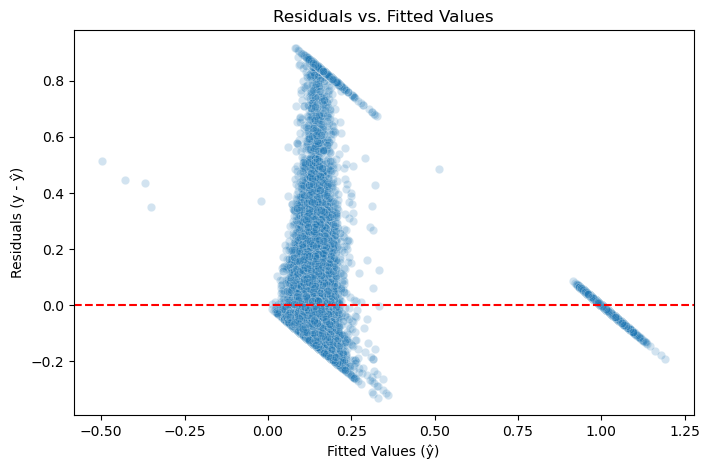

In [137]:
# Correct: sample the index, not the values
sample_idx = fitted_vals.sample(n=50000, random_state=1).index

# Now use the sampled index to slice
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals.loc[sample_idx],
                y=residuals.loc[sample_idx],
                alpha=0.2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values (ŷ)")
plt.ylabel("Residuals (y - ŷ)")
plt.title("Residuals vs. Fitted Values")
plt.show()
